# 5.1. Generative Adversarial Networks

The materials in this notebook are inspired from:
* code
  * https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py
  * https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* article https://arxiv.org/abs/1610.09585

This tutorial covers the basics of Generative Adversarial Networks (GAN). In a GAN, two neural networks contest with each other in the form of a zero-sum game, where one agent's gain is another agent's loss:
* **Generator** is trained to create samples that fool the *discriminator* network.
* **Discriminator** is trained to distinguish authentic from fake samples.

<img src="https://d2l.ai/_images/gan.svg"  width="400" height="200">

As the *generator* becomes better at faking samples, the *discriminator* becomes better at distinguishing authentic samples.

We explore a few new toy examples all in images of small resolution ($\le32 \times 32$):
* [MNIST](http://yann.lecun.com/exdb/mnist/): grey-scale digit recognition from 0 to 9.

<img src="https://www.researchgate.net/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png"  width="300" height="300">

* [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) grey-scale image recognition among 10 categories.

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png"  width="300" height="300">

* [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html): object recognition among 10 categories.

<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png"  width="300" height="300">

# 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [argparse](https://docs.python.org/3/library/argparse.html) is a module making it easy to write user-friendly command-line interfaces. 
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
import argparse
from matplotlib import pyplot as plt
import random
import os
import math

import torch
import torch.nn as nn
import torchvision

## device
Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## arguments

We use the `argparse` module to define a set of parameters that we use throughout this notebook:
* The `argparse` is particularly useful when writing Python scripts, allowing you to run the same script with different parameters (e.g., for doing different experiments).
* In notebooks using `argparse` is not necessarily beneficial, we could have hard-coded those values directly in variables, but here we use `argparse` for learning purposes.

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=500, help="interval between image sampling")
parser.add_argument("--out_dir", type=str, default="./gan_out/", help="the output directory")
parser.add_argument("--dataset", type=str, default="mnist", 
                    choices=["mnist", "fashion-mnist", "cifar10"], help="which dataset to use")

def set_args(*args):
    # we can pass arguments to the parse_args function to change the default values. 
    opt = parser.parse_args([*args])
    # adding the dataset to the out dir to avoid overwriting the generated images
    opt.out_dir = "%s/%s/" % (opt.out_dir, opt.dataset)
    
    # the images in cifar10 are colourful
    if opt.dataset == "cifar10":
        opt.channels = 3
    
    # creating the output directory
    os.makedirs(opt.out_dir, exist_ok=True)
    return opt

In [4]:
opt = set_args("--n_epochs", "5", "--dataset", "cifar10")
print(opt)

Namespace(n_epochs=5, batch_size=128, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=32, channels=3, sample_interval=500, out_dir='./gan_out//cifar10/', dataset='cifar10')


# Architectures

We have to define two architectures.
* The **generator** is input with a noise vector (e.g., with $100$ elements) and produces an image of size $32 \times 32$ (either in grey-scale or colourful).
* The **discriminator** is input with an image of $32 \times 32$ (either in grey-scale or colourful) and determines whether the image is authentic or fake (i.e., a binary classification).

## Generator

In our implementation of the `Generator` we use blocks of:
* Transposed convolution (`ConvTranspose2d`) gradually increases the spatial resolution,
* Batch normalisation `BatchNorm2d`,
* And `ReLU` activation function.

We use the `Tanh` to clip the outputs in the range $[-1, 1]$:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Hyperbolic_Tangent.svg/490px-Hyperbolic_Tangent.svg.png"  width="300">

In [5]:
class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()
        self.out_size = (opt.img_size, opt.img_size)
        num_features = 64
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(opt.latent_dim, num_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(True),
            # state size. ``(num_features*8) x 4 x 4``
            nn.ConvTranspose2d(num_features * 8, num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(True),
            # state size. ``(num_features*4) x 8 x 8``
            nn.ConvTranspose2d(num_features * 4, num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU(True),
            # state size. ``(num_features*2) x 16 x 16``
            nn.ConvTranspose2d(num_features * 2, num_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features),
            nn.ReLU(True),
            # state size. ``(num_features) x 32 x 32``
            nn.ConvTranspose2d(num_features, opt.channels, 1, bias=False),
            # state size. ``(opt.channels) x 32 x 32``
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Discriminator

The `Discriminator` has a symmetrical architecture to the `Generator` using blocks of:
* Convolution (`Conv2d`) that gradually decreases the spatial resolution,
* Batch normalisation `BatchNorm2d`,
* And `LeakyReLU` activation function.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_3.09.45_PM.png"  width="300">

The output is a binary classification (i.e., authentic versus fake). We use a fully convolutional implementation (i.e., the classification layer is also `Conv2d` instead of `Linear`layer) followed by the `Sigmoid`activation function.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, opt):
        super(Discriminator, self).__init__()
        num_features = 64
        self.main = nn.Sequential(
            # input is ``(opt.channels) x opt.img_size x opt.img_size``
            nn.Conv2d(opt.channels, num_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_features) x opt.img_size/2 x opt.img_size/2``
            nn.Conv2d(num_features, num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_features*2) x opt.img_size/4 x opt.img_size/4``
            nn.Conv2d(num_features * 2, num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_features*4) x opt.img_size/8 x opt.img_size/8``
            nn.Conv2d(num_features * 4, num_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(num_features*8) x opt.img_size/16 x opt.img_size/16``
            nn.Conv2d(num_features * 8, 1, 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Weights initialisation

It's a common practice to initialise the weights of GANs' networks from a normal distribution. This has been reported experimentally to produce betetr results.

In [7]:
def weights_init_normal(m):
    """reinitialising all (transpose-)convolutional and batch normalization layers."""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Dataset

We explore three datasets all already implemented in `torchvision`. The first time will be automatically downloaded (in *"./data/"* directory) the first time if already it doesn't exist.

In [8]:
def get_dataloader(opt, transform):
    if opt.dataset == "mnist":
        dataset = torchvision.datasets.MNIST("./data/", train=True, download=True, transform=transform)
    elif opt.dataset == "fashion-mnist":
        dataset = torchvision.datasets.FashionMNIST("./data/", train=True, download=True, transform=transform)
    else:
        dataset = torchvision.datasets.cifar.CIFAR10("./data/", train=True, download=True, transform=transform)
    return torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)

## Transform functions

We resize all images to specified image size (`opt.img_size`), converting them to `Tensor` and normalising the inputs (`Normalize`).

In [9]:
# make the pytorch datasets
mean = 0.5
std = 0.5
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(opt.img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

dataloader = get_dataloader(opt, transform)

Files already downloaded and verified


## Visualisation

Let's visualise a few samples from our dataset.

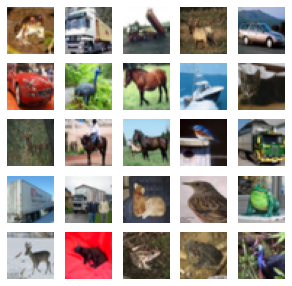

In [10]:
fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

# Training

## Setup Networks and Optimiser

In [11]:
def setup_training(opt):
    # Initialise generator and discriminator
    generator = Generator(opt).to(device)
    discriminator = Discriminator(opt).to(device)

    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

    # Optimisers
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

    return generator, discriminator, optimizer_g, optimizer_d

## Loss and ground-truths

In [14]:
# Loss functions
adversarial_loss = torch.nn.BCELoss().to(device)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(10 ** 2, opt.latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

## Utility functions

In [13]:
def sample_image(generator, batches_done):
    """Saves a grid of generated images."""
    with torch.no_grad():
        gen_imgs = generator(fixed_noise).detach().cpu()
    torchvision.utils.save_image(
        gen_imgs.data, "%s/%.7d.png" % (opt.out_dir, batches_done), nrow=10, normalize=True
    )

The training loop consists of three steps:
1. **Discriminator**
    * First, we train the discriminator with *"real"* images from our dataset.
    * Second, we train the discriminator with *"fake"* images obtained from generator.
2. **Generator**
    * Third, we train the generator in an effort to generate better fakes.

Note: in all three steps, we use a single loss function `adversarial_loss`, which we defined earlier as a *Binary Cross Entropy* (`BCELoss`). In other words, we always optimise with respect to how good/bad the *discriminator* is in detecting real/fake images.

In [15]:
def train_instance(opt):
    generator, discriminator, optimizer_g, optimizer_d = setup_training(opt)
    
    print(generator)
    print(discriminator)
    
    d_losses = []
    g_losses = []
    accs_d_x = []
    accs_d_z = []
    
    for epoch in range(opt.n_epochs):
        # For each batch in the dataloader
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            b_size = imgs.size(0)
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            ## Train with all-real batch
            discriminator.zero_grad()
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = discriminator(imgs).view(-1)
            # Calculate loss on all-real batch
            err_d_real = adversarial_loss(output, label)
            # Calculate gradients for D in backward pass
            err_d_real.backward()
            d_x = (output > 0.5).float().mean().item()
    
            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, opt.latent_dim, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            err_d_fake = adversarial_loss(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            err_d_fake.backward()
            d_z1 = (output < 0.5).float().mean().item()
            
            # Compute error of D as sum over the fake and the real batches
            err_d = err_d_real + err_d_fake
            # Update D
            optimizer_d.step()
            
            # -----------------
            #  Train Generator
            # -----------------
    
            generator.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            err_g = adversarial_loss(output, label)
            # Calculate gradients for G
            err_g.backward()
            d_z2 = (output < 0.5).float().mean().item()
            # Update G
            optimizer_g.step()
            
            # adding to log lists
            d_losses.append(err_d.item())
            g_losses.append(err_g.item())
            accs_d_x.append(d_x)
            accs_d_z.append((d_z1 + d_z2) / 2)
    
            batches_done = epoch * len(dataloader) + i
            if batches_done % opt.sample_interval == 0:
                sample_image(generator, batches_done)
                print(
                    "[Epoch %.3d/%d]\t[Batch %.4d/%d]\t[G loss: %.4f]\t[D loss: %.4f \taccs: x=%d%% \tz=%d%%] "
                    % (epoch, opt.n_epochs, i, len(dataloader), np.mean(g_losses), np.mean(d_losses), 
                       100 * np.mean(accs_d_x), 100 * np.mean(accs_d_z))
                )
    return generator, d_losses, g_losses, accs_d_x, accs_d_z

# Results

Let's train our GAN with current arguments (`opt`).

We print:
* **loss values** for generator and discriminator.
* **accuracies** of discriminator in detecting real images (*x*) and fake images (*z*). In theory, both these numbers start near 1 and should converge to 0.5 (the point where the generator is equally good real and fake images).

In [16]:
generator, d_losses, g_losses, accs_d_x, accs_d_z = train_instance(opt)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
 

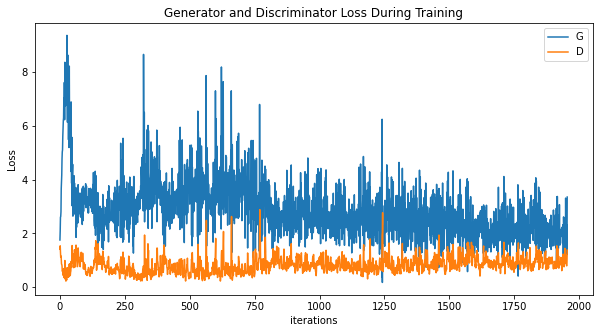

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Generating

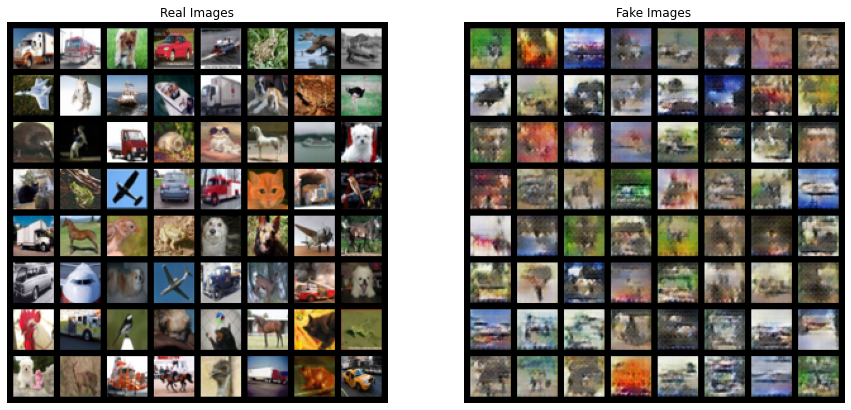

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


with torch.no_grad():
    gen_imgs = generator(fixed_noise).detach().cpu()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_imgs.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

# Another dataset

Let's play with another dataset!

Namespace(n_epochs=5, batch_size=128, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=32, channels=1, sample_interval=500, out_dir='./gan_out//fashion-mnist/', dataset='fashion-mnist')


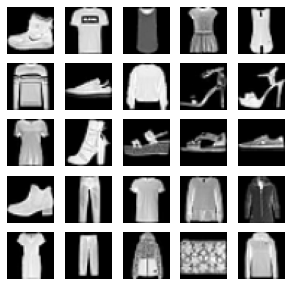

In [20]:
opt = set_args("--n_epochs", "5", "--dataset", "fashion-mnist")
print(opt)

dataloader = get_dataloader(opt, transform)

fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

In [21]:
generator, d_losses, g_losses, accs_d_x, accs_d_z = train_instance(opt)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
 

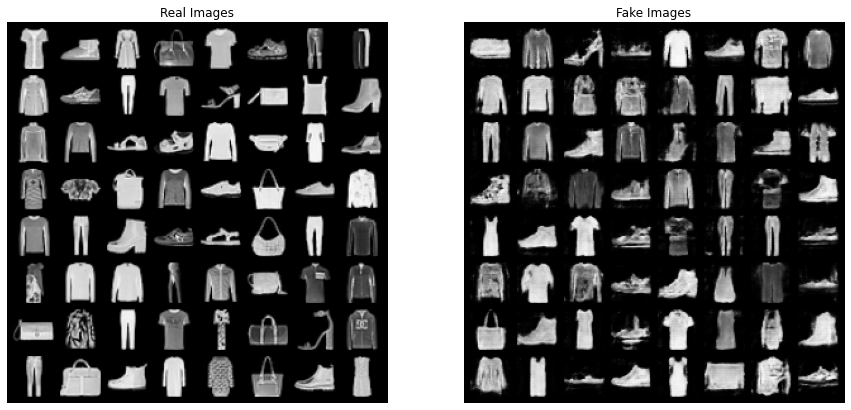

In [22]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


with torch.no_grad():
    gen_imgs = generator(fixed_noise).detach().cpu()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_imgs.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()